In [1]:
import joblib
import yaml
from os.path import join

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

data_path = config['paths']['data']
model_path = config['paths']['model']
firgure_path = config['paths']['figure']

In [3]:
train_path = join(data_path, 'raw/mitbih_train.csv')
test_path = join(data_path, 'raw/mitbih_test.csv')
abnormal_path = join(data_path, 'external/ptbdb_abnormal.csv')
normal_path = join(data_path, 'external/ptbdb_normal.csv')

# Data Partitioning

In [4]:
import pandas as pd

train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

In [ ]:
from summarytools import dfSummary

dfSummary(train_df, )

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,0[float64],Mean (sd) : 0.9 (0.2)min < med < max:0.0 < 1.0 < 1.0IQR (CV) : 0.1 (3.7),"23,408 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClklEQVR4nO3XPW/aUBiG4fdAgkwK58gQMWbplkjdsrC3Y35s124dGLo2K1OWKAoidiFYcYw7pJW6JME2hDzVfa3ogTPc/sCVZWnAe9fa9wGATRzs+wD4fzjnumbWqTl/KMty9dyHhIqtcM51h8Phhfc+rrNP03TunPv6XKyEim3peO/j8Xi8CiFkVYZJkkSTySSezWYdMyNU7F4IIRuNRvc1pt2XPuTPFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQc7PsAeD+cc10z69Sc+/V6fbjN8/yLUGFmT5EOh8ML731cZ5/neVQUxVmWZd/N7H7Lx3s91IZX2UNZlquaW7ytjvc+Ho/HqxBCVnV8dXUVX15eHj0+PrZ3cbgXQ216laVpOnfOfSXWt9PgxuLX6/VhCGE+Go0q3xHn83m3xm9u7LU7au2rLEmSaDKZxLPZrGNmhLqhhk+waDAYfAkhfKg63PWju6mN3lFDCFmdq6woCm9m3jlX+WB/7O3VoWEwLTNb19jVDs3sKTYzOzs/P/9xfHycVtnu+tHd1EahJkkSVf3i6+vrfp7nn05OTtrtdrvyO4+Z2d3d3cI5983Mau0biAaDwecQQq/qsCiKw+Vy+bHX601brVZeZfs3tNPT05/9fv9X1d++vb2NptPpUVEUtWNbLpfRzc3NUdXdYrGI6u436es3V7a52iAGFMcAAAAASUVORK5CYII="">",0(0.0%)
2,1[float64],Mean (sd) : 0.8 (0.2)min < med < max:0.0 < 0.8 < 1.0IQR (CV) : 0.2 (3.4),"42,845 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC70lEQVR4nO3dvU7jQBRA4TsJhCGxnERoQ0ezRYqVtqDMQ+zD8ggUeQLaFIguyo9sxUs2xvE2sNIWgdhjy3Ot87XREANH1nhkj02e5wL4rtP0AQDnuGj6ANAexphrEemVHH7I8/z11IeEikoYY65vbm5+hWE4LjM+juOtMebhVKyEin8cz4hhEAST2WwWD4fDfZGBURTZ+Xw+Xq/XPREhVJzmekZM09RmWfbj6urqcTKZ/C7xI64/+5BQ8aEXhuF4Npu9Fj0jioi8vLyMn56e+m9vb906Do5Q8Z/hcLgvc0bcbrefnhFdsTwFFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAo9Lt4zDbifh8Xi8rPp4qkKoLeKy28nHTif7/f5RRMrsdFIrQm2X0rud1L3TiStCbaEyu53UvdOJKy6moAKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpU4DY/z7i+j9Tnu/RdEKpHqnofqa936bsgVL94/T7SJhGqh3x9H2mTuJiCCpxRa9DWR5abRKgVa/Mjy00i1Oq19pHlJhFqTdr4yHKTuJiCCoQKFQgVKjBHPYElJr98GarjTRKHPM9fS45tDEtM/vk0VNebJOI43hpjHhTGyhKTZ746o5b+h0VRZOfz+Xi9XvdERFuoIsISk0/OmqOWvUkiy7JQREJjTOEDe6dy6oDq1XYxlSTJZZqmP+/u7rrdbrfwLWsiqqcOqFhtoR4Ohwtrbf/+/n5/e3u7LTq+DVMHVKf25anBYFBq2iDiPHXoiMixzEBhick73q6jukwdsiy7TJLkexAEi06nkxb9bpaY/HNWqFEU2aI/eLfbWRGRJEnscrnsFx2/2WwCa21/Op2a0Wj0p8jY1WplF4vFt+l0+jwajXZFv/t9fD+KosFyuTwUGevye7v+zbR+9zl9/QXor2yswMnDrQAAAABJRU5ErkJggg=="">",0(0.0%)
3,2[float64],Mean (sd) : 0.4 (0.2)min < med < max:0.0 < 0.4 < 1.0IQR (CV) : 0.3 (1.9),"49,611 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmElEQVR4nO3cTW7iMBiA4c9DgfCjRAgJdlxgpFmwzCHmsHOELjgBN2CHhFAQmUaEkNmNNBJtSewM/tz32bvN4lUb27FNXdcC+O7bsx8AeMTLsx/AV8aYkYgMWg6/1HX95vJ5vjpCvcMYM5rP5z/jOJ61GX86nY7GmF/E6g6h3jeI43iWpulbkiRFk4FZlkWbzWZ2OBwGIkKojhDqB5IkKRaLxe8WQ0fOH+aLYzIFFQgVKvCvvwNVVfVFJDbGtBnOisEdhOpYnuf9six/rFarXq/XazQRE2HF4D2E6tjlcnmJomi8Xq+L5XJ5bDKWFYP3EWpHJpMJKwYOBRuq5c5SfLvd+i6fB3aCDNV2Z6ksy6iqqu9FUbyKSJu/inAsyFDFYmdJRGS328222+34er32ung4NBdqqCLSfmfpeDzynugZFvyhAqFCBUKFCoQKFQgVKng967dYtGfBPjDehmqzaM+CfXi8DVUsFu1ZsA+Pz6GKSLtFexbsw8NkCioQKlQgVKhAqFCBUKFCp7N+vrJvzvIEq0igp1g7C5Wv7JuzPcEqEu4p1k9DtdnGnE6nizRNT3xl/xibE6wiYZ9i/TBUF9uYw+Hwla/sm7E4wSoS6CnWz/6iso0JLzz0jso2Jp6N5SmoQKhQgVChAqFCBe+/R0Uzod7NSqgBCfluVkINSMh3sxJqgEK8m5XJFFQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgb1+/OXz5ReEChHx//ILQoWI+H/5BaHiH75efsFkCioQKlQgVKjAOyqc6fIELKHCia5PwBIqnOj6BCyhwqmuTsAymYIKhAoVCBUqPPSOmmVZ1PQHn8/nSEQkz/Nov9+P/+d4rb9b63Pbjn+krz/0G7TVilaWcwAAAABJRU5ErkJggg=="">",0(0.0%)
4,3[float64],Mean (sd) : 0.2 (0.2)min < med < max:0.0 < 0.2 < 1.0IQR (CV) : 0.3 (1.1),"41,0

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

y = train_df[187]
X = train_df.drop(columns=[187, ])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y_test = test_df[187]
X_test = test_df.drop(columns=[187, ])

# Model Training

In [8]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [9]:
svc.score(X_train, y_train)

0.9693759547706409

In [10]:
svc.score(X_val, y_val)

0.9681914225344069

Seem well-fitted

In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svc, X, y, cv=5)
print("\nCross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-validation Scores: [0.96562161 0.96984752 0.96670664 0.96767746 0.96750428]
Mean CV Score: 0.9674715036752131


Quite Good

# Evaluate 

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score

y_pred = svc.predict(X_test)

In [13]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.9670655947378037


In [14]:
bas = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Acc on Testset: {bas}')

Balanced Acc on Testset: 0.756042097757875


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     18118
         1.0       0.96      0.56      0.71       556
         2.0       0.97      0.86      0.91      1448
         3.0       0.76      0.46      0.57       162
         4.0       1.00      0.90      0.95      1608

    accuracy                           0.97     21892
   macro avg       0.93      0.76      0.82     21892
weighted avg       0.97      0.97      0.96     21892



In [23]:
cm = confusion_matrix(y_test, y_pred, normalize='pred')
print(cm)

[[0.96597767 0.03384615 0.01397516 0.         0.0020562 ]
 [0.01271164 0.96       0.00465839 0.         0.        ]
 [0.0094002  0.00615385 0.96661491 0.2371134  0.0013708 ]
 [0.00411259 0.         0.00854037 0.7628866  0.        ]
 [0.0077979  0.         0.00621118 0.         0.996573  ]]


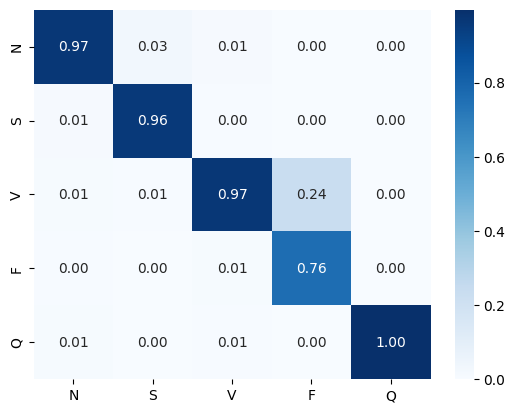

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["N", "S", "V", "F", "Q"] 

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.savefig(join(firgure_path, 'Confusion_Matrix.png'))
plt.show()

In [25]:
joblib.dump(svc, join(model_path, 'Support_Vector_Machine_Classification.pkl'))

['D:/Workspace/Machine_Learning/mlmed2025/Practice_1/model\\Support_Vector_Machine_Classification.pkl']

# Data Balancing

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [28]:
print("Class Distribution after SMOTE:")
print(pd.Series(y_smote).value_counts())

Class Distribution after SMOTE:
187
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [30]:
svc_smote = SVC()
svc_smote.fit(X_train, y_train)

SVC()

In [31]:
svc_smote.score(X_val, y_val)

0.9706089332284638

In [32]:
svc_smote.score(X_train, y_train)

0.9717300713388803

In [33]:
y_pred_smote = svc_smote.predict(X_test)

In [34]:
acc_smote = accuracy_score(y_test, y_pred_smote)
acc

0.9670655947378037

In [36]:
bas = balanced_accuracy_score(y_test, y_pred_smote)
bas

0.9166255831673826

Much better

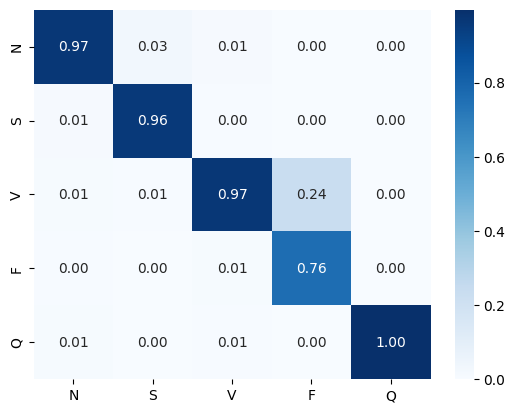

In [37]:
cm_SMOTE = confusion_matrix(y_test, y_pred, normalize='pred')
class_labels = ["N", "S", "V", "F", "Q"] 

sns.heatmap(cm_SMOTE, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.savefig(join(firgure_path, 'Confusion_Matrix_applying_SMOTE.png'))
plt.show()